In [1]:
# barplot
# https://12jeong.github.io/python-barplot/

# plot color
# https://matplotlib.org/stable/gallery/color/named_colors.html

# 신뢰 구간
# https://angie-gil.medium.com/평점-순으로-정렬하지-않는-법-이론편-9ced2f26bc4b

# cv
# https://coding-potato.tistory.com/15
# https://jimmy-ai.tistory.com/178

# Import Dataset and Libraries

In [2]:
from typing import Any
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
plt.rc('font', family='Malgun Gothic')

In [3]:
preprocess_file = "./preprocessing.csv"

drop_columns = [
    'index',
    'date',
#    'round',
#    'game_count',
#    'game_goal',
#    'cur_game_count',
#    'win_odds',
#    'lose_odds',
    'track_E',
#    'cc',
#    'part_people',
#    'rank',
#    'prefix_rank',
    'odds_result',
    'significant',
#    'RESULT',
#    'track_E_encoded',
#    'odds_result_SU',
#    'odds_result_UD',
]

df_pp = pd.read_csv(preprocess_file)
df_pp = df_pp.drop(drop_columns, axis=1)

In [4]:
df_pp.head()

,round,game_count,game_goal,cur_game_count,win_odds,lose_odds,cc,part_people,rank,prefix_rank,RESULT,track_E_encoded,odds_result_SU,odds_result_UD
0,1,3,15,1,4.71,1.27,150,10,10,10,False,41,1,0
1,1,3,15,2,4.71,1.27,150,12,7,17,False,20,1,0
2,2,3,15,1,7.04,1.17,150,11,2,2,True,41,0,1
3,2,3,15,2,7.04,1.17,150,11,5,7,True,0,0,1
4,2,3,15,3,7.04,1.17,150,12,5,12,True,18,0,1


In [5]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   round            620 non-null    int64  
 1   game_count       620 non-null    int64  
 2   game_goal        620 non-null    int64  
 3   cur_game_count   620 non-null    int64  
 4   win_odds         620 non-null    float64
 5   lose_odds        620 non-null    float64
 6   cc               620 non-null    int64  
 7   part_people      620 non-null    int64  
 8   rank             620 non-null    int64  
 9   prefix_rank      620 non-null    int64  
 10  RESULT           620 non-null    bool   
 11  track_E_encoded  620 non-null    int64  
 12  odds_result_SU   620 non-null    int64  
 13  odds_result_UD   620 non-null    int64  
dtypes: bool(1), float64(2), int64(11)
memory usage: 63.7 KB


# Modeling Data Subset

In [6]:
X = df_pp
X, y_rank, y_result = X.drop(['rank', 'RESULT'], axis=1), X['rank'], X['RESULT'].astype(bool)

In [7]:
X.head()

,round,game_count,game_goal,cur_game_count,win_odds,lose_odds,cc,part_people,prefix_rank,track_E_encoded,odds_result_SU,odds_result_UD
0,1,3,15,1,4.71,1.27,150,10,10,41,1,0
1,1,3,15,2,4.71,1.27,150,12,17,20,1,0
2,2,3,15,1,7.04,1.17,150,11,2,41,0,1
3,2,3,15,2,7.04,1.17,150,11,7,0,0,1
4,2,3,15,3,7.04,1.17,150,12,12,18,0,1


# Modeling

In [8]:
!python --version

Python 3.11.5


In [9]:
# !python.exe -m pip install --upgrade pip
# !pip install scikit-learn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score
from sklearn.base import BaseEstimator

# Classification Model Import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Regression Model Import
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [11]:
clf_model_dict = {
    "clf_ridge": LogisticRegression(penalty='l2'),
    "clf_lasso": LogisticRegression(penalty='l1'),
    "clf_logistic_regression": LogisticRegression(),
    "clf_logistic_regression_": LogisticRegression(solver='liblinear'),
    "clf_adaboost": AdaBoostClassifier(),
    "clf_gradient_boosting": GradientBoostingClassifier(),
    "clf_random_forest": RandomForestClassifier(),
    "clf_xgb": XGBClassifier(),
    "clf_xgb_": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "clf_lgbm": LGBMClassifier(),
    "clf_catboost": CatBoostClassifier(verbose=0),
}

reg_model_dict = {
    "reg_ridge": Ridge(),
    "reg_lasso": Lasso(),
    "reg_linear_regression": LinearRegression(),
    "reg_adaboost": AdaBoostRegressor(),
    "reg_gradient_boosting": GradientBoostingRegressor(),
    "reg_random_forest": RandomForestRegressor(),
    "reg_xgb": XGBRegressor(),
    "reg_lgbm": LGBMRegressor(),
    "reg_catboost": CatBoostRegressor(verbose=0),
}

# Training Model

In [12]:
from sklearn.model_selection import train_test_split


def fit_model(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[BaseEstimator, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = test_size,
        random_state = random_state
    )
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

# Evaluate Model

## Classification

In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


def eval_clf_model(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)      # 정확도
    precision = precision_score(y, y_pred)    # 정밀도
    recall = recall_score(y, y_pred)          # 재현율
    f1 = f1_score(y, y_pred)                  # F1 점수
    roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

## Regression

In [19]:
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)


def eval_reg_model(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)                # R² 점수
    mae = mean_absolute_error(y, y_pred)    # 평균 절대 오차 (MAE)
    mse = mean_squared_error(y, y_pred)     # 평균 제곱 오차 (MSE)
    rmse = mean_squared_error(y, y_pred, squared=False)    # 평균 제곱근 오차 (RMSE)

    return r2, mae, mse, rmse

# K-Fold Cross Validation

In [126]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

## Classification

In [157]:
# cross_val_score의 estimator가 classifier 종류이면 내부적으로 stratified KFold 로 진행
def clf_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_acc'] = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    scores1['cvs_pre'] = cross_val_score(model, X, y, cv=cv, scoring='precision')
    scores1['cvs_rec'] = cross_val_score(model, X, y, cv=cv, scoring='recall')
    scores1['cvs_f1 '] = cross_val_score(model, X, y, cv=cv, scoring='f1')
    scores1['cvs_roc'] = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_acc'] = cross_val_score(model, X, y, cv=skfolds, scoring='accuracy')
    scores2['mix_pre'] = cross_val_score(model, X, y, cv=skfolds, scoring='precision')
    scores2['mix_rec'] = cross_val_score(model, X, y, cv=skfolds, scoring='recall')
    scores2['mix_f1 '] = cross_val_score(model, X, y, cv=skfolds, scoring='f1')
    scores2['mix_roc'] = cross_val_score(model, X, y, cv=skfolds, scoring='roc_auc')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = clf_model_dict['clf_logistic_regression']
        model.fit(X_train, y_train)
        scores = eval_clf_model(model, X_val, y_val)
        accuracy, precision, recall, f1, roc_auc = scores
        
        scores3['skf_acc'].append(accuracy)
        scores3['skf_pre'].append(precision)
        scores3['skf_rec'].append(recall)
        scores3['skf_f1 '].append(f1)
        scores3['skf_roc'].append(roc_auc)
    
    return scores1,scores2, scores3

In [158]:
model = clf_model_dict['clf_logistic_regression_']
model, X_train, X_test, y_train, y_test = fit_model(model, X, y_result)
scores1,scores2, scores3 = clf_cross_validation(model, X_train, y_train, 5)

# Scores1: cross_val_score
for key, value in scores1.items():
    print(f'{key}: {np.mean(value)}')
    
# Scores2: StratifiedKFold by cross_val_score
for key, value in scores2.items():
    print(f'{key}: {np.mean(value)}')

# Scores3: StratifiedKFold score
for key, value in scores3.items():
    print(f'{key}: {np.mean(value)}')

cvs_acc: 0.9051919191919191
cvs_pre: 0.8421145617667356
cvs_rec: 0.7971509971509971
cvs_f1 : 0.817695361242531
cvs_roc: 0.952388587510353
mix_acc: 0.9112929292929293
mix_pre: 0.8676945373467113
mix_rec: 0.7894586894586894
mix_f1 : 0.8262378158810695
mix_roc: 0.9507432558421904
skf_acc: 0.9032121212121214
skf_pre: 0.8571424951859734
skf_rec: 0.7672364672364671
skf_f1 : 0.8089765113592607
skf_roc: 0.9473218505943011


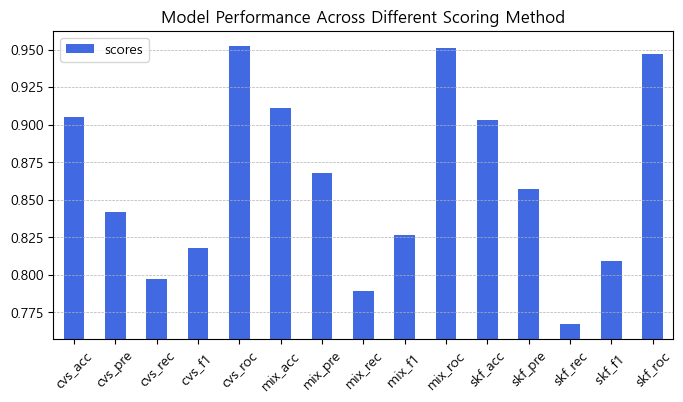

In [159]:
keys = (
    [k for k in scores1.keys()] + 
    [k for k in scores2.keys()] + 
    [k for k in scores3.keys()]
)
values = (
    [np.mean(v) for v in scores1.values()] + 
    [np.mean(v) for v in scores2.values()] + 
    [np.mean(v) for v in scores3.values()]
)

df_tmp = pd.DataFrame({
    "scores": values
})
df_tmp.index = keys

df_tmp.plot.bar(
    figsize = (8, 4),
    title= "Model Performance Across Different Scoring Method",
    color = ["royalblue", ],
    label = ["scoring 점수", ],
    xlabel = "",
    ylabel = "",
    ylim = [min(values)-0.01, max(values)+0.01],
    rot = 45,
)
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

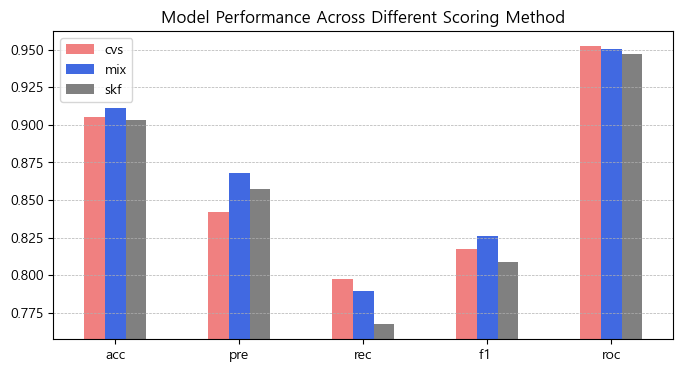

In [174]:
scores = [(np.mean(c), np.mean(m), np.mean(s))
          for c, m, s in zip(scores1.values(), scores2.values(), scores3.values())]

df_tmp = pd.DataFrame({
    "acc": scores[0],
    "pre": scores[1],
    "rec": scores[2],
    "f1 ": scores[3],
    "roc": scores[4],
})
df_tmp.index = ["cvs", "mix", "skf"]

df_tmp.T.plot.bar(
    figsize = (8, 4),
    title= "Model Performance Across Different Scoring Method",
    color = ['lightcoral', 'royalblue', 'grey',],
    label = ["scoring 점수", ],
    xlabel = "",
    ylabel = "",
    ylim = [min(map(min,scores))-0.01, max(map(max,scores))+0.01],
    rot = 0,
)
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

In [179]:
def reg_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_r2'] = cross_val_score(model, X, y, cv=cv, scoring='r2')
    scores1['cvs_mae'] = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    scores1['cvs_mse'] = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores1['cvs_rmse'] = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_r2'] = cross_val_score(model, X, y, cv=skfolds, scoring='r2')
    scores2['mix_mae'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_mean_absolute_error')
    scores2['mix_mse'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_mean_squared_error')
    scores2['mix_rmse'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_root_mean_squared_error')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = reg_model_dict['reg_linear_regression']
        model.fit(X_train, y_train)
        scores = eval_reg_model(model, X_val, y_val)
        r2, mae, mse, rmse = scores
        
        scores3['skf_r2'].append(r2)
        scores3['skf_mae'].append(mae)
        scores3['skf_mse'].append(mse)
        scores3['skf_rmse'].append(rmse)
    
    return scores1,scores2, scores3

In [180]:
model = reg_model_dict['reg_linear_regression']
model, X_train, X_test, y_train, y_test = fit_model(model, X, y_result)
scores1,scores2, scores3 = reg_cross_validation(model, X_train, y_train, 5)

# Scores1: cross_val_score
for key, value in scores1.items():
    print(f'{key}: {np.mean(value)}')
    
# Scores2: StratifiedKFold by cross_val_score
for key, value in scores2.items():
    print(f'{key}: {np.mean(value)}')

# Scores3: StratifiedKFold score
for key, value in scores3.items():
    print(f'{key}: {np.mean(value)}')

cvs_r2: 0.5435164670676167
cvs_mae: -0.21528410460056185
cvs_mse: -0.08791246175344569
cvs_rmse: -0.2951484780604877
mix_r2: 0.5537143248159189
mix_mae: -0.2161329425972501
mix_mse: -0.08757256364645025
mix_rmse: -0.2953140154718113
skf_r2: 0.5537143248159189
skf_mae: 0.2161329425972501
skf_mse: 0.08757256364645025
skf_rmse: 0.2953140154718113


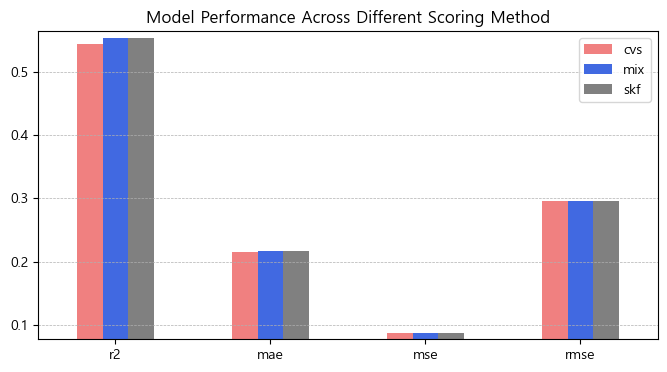

In [185]:
scores = [(abs(np.mean(c)), abs(np.mean(m)), abs(np.mean(s)))
          for c, m, s in zip(scores1.values(), scores2.values(), scores3.values())]

df_tmp = pd.DataFrame({
    "r2": scores[0],
    "mae": scores[1],
    "mse": scores[2],
    "rmse": scores[3],
})
df_tmp.index = ["cvs", "mix", "skf"]

df_tmp.T.plot.bar(
    figsize = (8, 4),
    title= "Model Performance Across Different Scoring Method",
    color = ['lightcoral', 'royalblue', 'grey',],
    label = ["scoring 점수", ],
    xlabel = "",
    ylabel = "",
    ylim = [min(map(min,scores))-0.01, max(map(max,scores))+0.01],
    rot = 0,
)
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

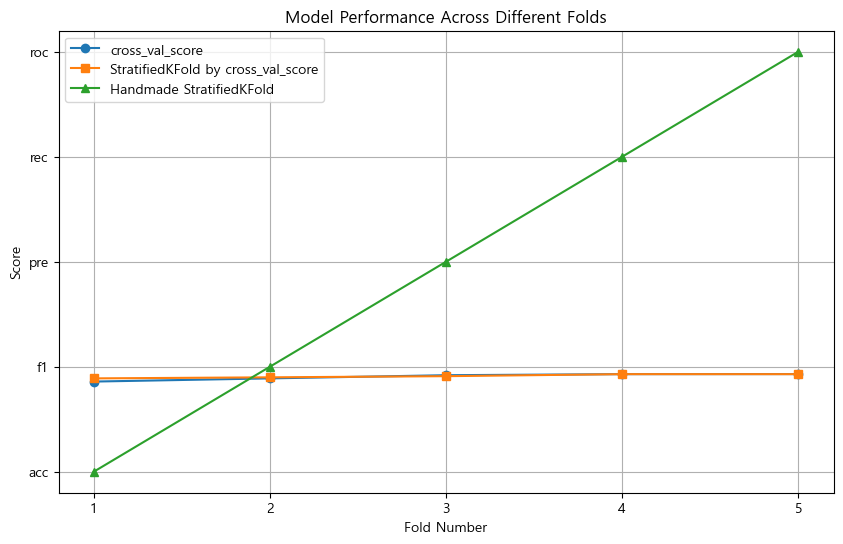

In [30]:
# 데이터
cross_val_score_results = sorted(scores1)
stratified_by_cross_val_score_results = sorted(scores2)
# handmade_stratified_kfold_results = sorted(scores3)

# Fold 번호
folds = np.arange(1, 6)

plt.figure(figsize=(10, 6))
plt.plot(
    folds,
    cross_val_score_results,
    marker='o', 
    color='tab:blue',
    label='cross_val_score'
)

plt.plot(
    folds,
    stratified_by_cross_val_score_results,
    marker='s',
    color='tab:orange',
    label='StratifiedKFold by cross_val_score'
)

plt.plot(
    folds,
    handmade_stratified_kfold_results,
    marker='^',
    color='tab:green',
    label='Handmade StratifiedKFold'
)

# 제목 및 라벨 설정
plt.title('Model Performance Across Different Folds')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.xticks(folds)

# 범례 및 그리드 추가
plt.legend()
plt.grid(True)

# Test model

## Classification

In [ ]:
# columns_name = [
#     'game_count',
#     'game_goal',
#     'cur_game_count',
#     'cc',
#     'part_people',
#     'track_E_encoded',
# ]

# new_data = [
#     1,    # 'game_count'
#     12,   # 'game_goal'
#     2,    # 'cur_game_count'
#     150,  # 'cc'
#     12,   # 'part_people'
#     71,  # 'track_E_encoded'
# ]

# df = pd.DataFrame([new_data], columns=columns_name)
# proba = rank_model.predict(df)
# f'{proba[0]:.0f}등'

## Regression

In [ ]:
# columns_name = [
#     'game_count',
#     'game_goal',
#     'cur_game_count',
#     'cc',
#     'part_people',
#     'track_E_encoded',
# ]

# new_data = [
#     1,    # 'game_count'
#     12,   # 'game_goal'
#     2,    # 'cur_game_count'
#     150,  # 'cc'
#     12,   # 'part_people'
#     71,  # 'track_E_encoded'
# ]

# df = pd.DataFrame([new_data], columns=columns_name)
# proba = result_model.predict_proba(df)
# f, t = proba.flatten()

# print(f"True  probability: {t}")
# print(f"False probability: {f}")

# Hyperparameter Tuning

In [20]:
# https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C


def hyper_tuning():
    # No5 cv
    param_grid = {
        "C": [0.1, 1, 10, 100],
    }
    grid_search = GridSearchCV(model, param_grid, cv = 5)
    grid_search.fit(X, y)
    
    return grid_search.best_params_, grid_search.best_score_